In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

'''import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))'''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"import os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        pass\n        #print(os.path.join(dirname, filename))"

# This notebook was developed in a Kaggle Environment

# Setup

In [ ]:
pip install --upgrade keras tensorflow

In [ ]:
pip install scikeras

In [ ]:
pip install -U "tensorflow"

In [ ]:
pip install "tensorflow<=2.10.1"

In [ ]:
pip install "keras<=2.10.1"

In [ ]:
import os
import glob
import random
import ntpath
import datetime
import time as tm
from time import time
from operator import itemgetter

import numpy as np
import pandas as pd

from scipy import ndimage, signal         
from skimage.util.shape import view_as_blocks
import cv2

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, cohen_kappa_score, hamming_loss, log_loss,
    zero_one_loss, matthews_corrcoef, precision_recall_fscore_support
)

from yellowbrick.classifier import (
    ClassificationReport, ClassPredictionError, ConfusionMatrix, ROCAUC, PrecisionRecallCurve
)
from yellowbrick.style import find_text_color
from yellowbrick.style.palettes import color_sequence

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

from scikeras.wrappers import KerasClassifier


2025-10-31 10:05:56.197461: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761905156.399243      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761905156.451619      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
from tensorflow.keras.utils import to_categorical

# SRM Filter

In [5]:
srm_weights = np.load('/kaggle/input/srm-kernels/other/srm_kernels/1/SRM_Kernels1.npy') 
biasSRM=np.ones(30)
print (srm_weights.shape)

(5, 5, 1, 30)


In [ ]:
T3 = 3
def Tanh3(x):
    tanh3 = tf.keras.backend.tanh(x) * T3
    return tanh3

In [7]:
n=256
def load_images(path_pattern):
    files=glob.glob(path_pattern)
    X=[]
    for f in sorted(files):
        I = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        patches = view_as_blocks(I, (n, n))
        for i in range(patches.shape[0]):
            for j in range(patches.shape[1]):
                X.append( [ patches[i,j] ] )
    X=np.array(X)
    return X

In [ ]:
pathc = '/kaggle/input/bossbase-bows2/GBRASNET/BOSSbase-1.01'
paths = '/kaggle/input/bossbase-bows2/GBRASNET/BOSSbase-1.01/stego/S-UNIWARD/0.4bpp'

Xc_ = load_images(pathc+'/cover/*.pgm') ##COVER IMAGES
Xs_ = load_images(paths+'/stego/*.pgm') ##STEGO IMAGES
X_  = (np.vstack((Xc_, Xs_)))
Xt_ = (np.hstack(([0]*len(Xc_), [1]*len(Xs_))))
Xt_ = to_categorical(Xt_, 2)
X_  = np.rollaxis(X_,1,4)  #channel axis shifted to last axis

In [9]:
print("Total image data and labels",X_.shape,Xt_.shape)
#Cover hasta las 10000 ##Train hasta las 4000 ##Valid hasta de las 4000 a las 5000 ##Test de las 5000 a las 10000
X_train = np.concatenate([X_[0:4000],X_[10000:14000]],axis=0)
X_valid = np.concatenate([X_[4000:5000],X_[14000:15000]],axis=0)
X_test  = np.concatenate([X_[5000:10000],X_[15000:20000]],axis=0)
y_train = np.concatenate([Xt_[0:4000],Xt_[10000:14000]],axis=0)
y_valid = np.concatenate([Xt_[4000:5000],Xt_[14000:15000]],axis=0)
y_test  = np.concatenate([Xt_[5000:10000],Xt_[15000:20000]],axis=0)
#Controled randomized data for training
X_dat0, X_dat1, y_dat0, y_dat1 = train_test_split(X_train, y_train, test_size=0.50, random_state=64) 
X_train = np.concatenate([X_dat0,X_dat1],axis=0) 
y_train = np.concatenate([y_dat0,y_dat1],axis=0) 
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

Total image data and labels (20000, 256, 256, 1) (20000, 2)
(8000, 256, 256, 1)
(8000, 2)
(2000, 256, 256, 1)
(2000, 2)
(10000, 256, 256, 1)
(10000, 2)


# Self Supervised Consistency Distillation 

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

class ConsistencyDistillationModule:
    def __init__(self, temperature=0.1, consistency_weight=1.0):
        self.temperature = temperature
        self.consistency_weight = consistency_weight
        print(f"Consistency Distillation Module initialized (temp={temperature}, weight={consistency_weight})")
    
    def augment_batch(self, images, augmentation_type='strong'):
        batch_size = tf.shape(images)[0]
        
        if augmentation_type == 'weak':
            # Weak augmentations - slight modifications
            augmented = tf.image.random_brightness(images, max_delta=0.1)
            augmented = tf.image.random_contrast(augmented, lower=0.9, upper=1.1)
            augmented = tf.clip_by_value(augmented, 0.0, 1.0)
            
        elif augmentation_type == 'strong':
            # Strong augmentations - more aggressive
            augmented = tf.image.random_brightness(images, max_delta=0.2)
            augmented = tf.image.random_contrast(augmented, lower=0.8, upper=1.2)
            # Random rotation
            augmented = tf.keras.layers.RandomRotation(0.1)(augmented)
            # Random zoom
            augmented = tf.keras.layers.RandomZoom(0.1)(augmented)
            augmented = tf.clip_by_value(augmented, 0.0, 1.0)
            
        else: 
            # Geometric transformations
            augmented = tf.keras.layers.RandomRotation(0.2)(images)
            augmented = tf.keras.layers.RandomZoom(0.2)(augmented)
            augmented = tf.keras.layers.RandomTranslation(0.1, 0.1)(augmented)
        
        return augmented
    
    def consistency_loss(self, teacher_features, student_features):
        # Normalize features
        teacher_features = tf.math.l2_normalize(teacher_features, axis=1)
        student_features = tf.math.l2_normalize(student_features, axis=1)
        
        # Compute similarity matrix
        similarity_matrix = tf.matmul(teacher_features, student_features, transpose_b=True)
        similarity_matrix /= self.temperature
        
        # Create targets (diagonal should be high similarity)
        batch_size = tf.shape(teacher_features)[0]
        targets = tf.eye(batch_size)
        
        # Cross-entropy loss
        loss = tf.keras.losses.categorical_crossentropy(
            targets, similarity_matrix, from_logits=True
        )
        
        return tf.reduce_mean(loss)
    
    def feature_similarity_matrix(self, features1, features2):
        features1_norm = tf.math.l2_normalize(features1, axis=1)
        features2_norm = tf.math.l2_normalize(features2, axis=1)
        
        similarity = tf.matmul(features1_norm, features2_norm, transpose_b=True)
        return similarity.numpy()

    def compute_consistency_score(self, original_features, augmented_features):
        # Normalize features
        original_norm = tf.math.l2_normalize(original_features, axis=1)
        augmented_norm = tf.math.l2_normalize(augmented_features, axis=1)
        
        # Compute cosine similarity
        similarity = tf.reduce_sum(original_norm * augmented_norm, axis=1)
        return tf.reduce_mean(similarity).numpy()


def create_consistency_teacher_model(base_model):
    teacher_model = tf.keras.models.clone_model(base_model)
    teacher_model.set_weights(base_model.get_weights())
    return teacher_model

def update_teacher_weights(teacher_model, student_model, alpha=0.999):
    teacher_weights = teacher_model.get_weights()
    student_weights = student_model.get_weights()
    
    new_weights = []
    for tw, sw in zip(teacher_weights, student_weights):
        new_weights.append(alpha * tw + (1 - alpha) * sw)
    
    teacher_model.set_weights(new_weights)
    return teacher_model

def analyze_single_image_consistency(consistency_module, feature_extractor, image):
    original_feat = feature_extractor.predict(image, verbose=0)
    
    aug_types = ['weak', 'strong']
    similarities = []
    
    for aug_type in aug_types:
        aug_img = consistency_module.augment_batch(image, aug_type)
        aug_feat = feature_extractor.predict(aug_img, verbose=0)
        
        # Cosine similarity
        similarity = np.dot(original_feat[0], aug_feat[0]) / (
            np.linalg.norm(original_feat[0]) * np.linalg.norm(aug_feat[0])
        )
        similarities.append(similarity)
    
    return np.mean(similarities)

# DAN Model 

In [ ]:
def DAN_Model():
    tf.keras.backend.clear_session()
    
    # Input Stage
    inputs = tf.keras.Input(shape=(256, 256, 1), name="input")
    
    def tanh3_activation(x):
        return tf.math.tanh(x) * 3
    
    # SRM Preprocessing
    srm_layer = tf.keras.layers.Conv2D(30, (5, 5), strides=(1, 1), padding='same', 
                                     trainable=False, activation=tanh3_activation, use_bias=True)
    x = srm_layer(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Encoder with attention
    def channel_attention(x, filters, reduction=8):
        gap = tf.keras.layers.GlobalAveragePooling2D()(x)
        gap = tf.keras.layers.Dense(filters // reduction, activation='relu')(gap)
        gap = tf.keras.layers.Dense(filters, activation='sigmoid')(gap)
        gap = tf.keras.layers.Reshape((1, 1, filters))(gap)
        return tf.keras.layers.Multiply()([x, gap])
    
    # Main encoder (Student pathway)
    x = tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = channel_attention(x, 32)
    
    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = channel_attention(x, 64)
    
    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = channel_attention(x, 128)
    
    # Global features for consistency learning
    global_features = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Feature projector for consistency (additional layers for feature projection)
    consistency_features = tf.keras.layers.Dense(256, activation='relu', name='consistency_projection')(global_features)
    consistency_features = tf.keras.layers.BatchNormalization()(consistency_features)
    consistency_features = tf.keras.layers.Dense(128, activation='relu', name='consistency_features')(consistency_features)
    
    # Classifier Branch
    classifier_branch = tf.keras.layers.Dense(128, activation='relu')(global_features)
    classifier_branch = tf.keras.layers.BatchNormalization()(classifier_branch)
    classifier_branch = tf.keras.layers.Dropout(0.4)(classifier_branch)
    classifier_branch = tf.keras.layers.Dense(64, activation='relu')(classifier_branch)
    classifier_branch = tf.keras.layers.Dropout(0.3)(classifier_branch)
    classifier_branch = tf.keras.layers.Dense(32, activation='relu')(classifier_branch)
    classifier_output = tf.keras.layers.Dense(2, activation='softmax', name='classifier')(classifier_branch)
    
    # Generator Branch
    gen_branch = tf.keras.layers.Dense(128, activation='relu')(global_features)
    gen_branch = tf.keras.layers.Dense(256, activation='relu')(gen_branch)
    gen_branch = tf.keras.layers.Dense(64 * 64 * 1, activation='sigmoid')(gen_branch)
    generator_output = tf.keras.layers.Reshape((64, 64, 1), name='generator')(gen_branch)
    
    model = tf.keras.Model(
        inputs=inputs, 
        outputs=[
            classifier_output, 
            generator_output,
            consistency_features  
        ]
    )
    
    srm_layer.set_weights([srm_weights, biasSRM])
    
    print("DAN Model with Consistency Distillation Generated")
    return model

# Training (Main Code)

In [ ]:
def train(model, X_train, y_train, X_valid, y_valid, 
                   batch_size=16, epochs=200, model_name=""):
    
    import datetime
    import os
    
    log_dir = f"./logs/{model_name}_{datetime.datetime.now().isoformat()[:19].replace('T', '_').replace(':', '-')}"
    os.makedirs(log_dir, exist_ok=True)

    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_classifier_accuracy',
        patience=30,  # 10 -> 30
        restore_best_weights=True,
        mode='max',
        verbose=1,
        min_delta=0.001 
    )
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_classifier_loss',
        factor=0.5,
        patience=15,  # 5 -> 15
        min_lr=1e-7,
        verbose=1
    )
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        log_dir + "/best_model.keras",
        monitor='val_classifier_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
    
    num_samples = len(X_train)
    num_valid_samples = len(X_valid)
    
    X_train_gen_targets = np.zeros((num_samples, 64, 64, 1), dtype=np.float32)
    for i in range(num_samples):
        img = tf.cast(X_train[i], tf.float32) / 255.0
        downsampled = tf.image.resize(img, [64, 64])
        X_train_gen_targets[i] = downsampled
    
    X_valid_gen_targets = np.zeros((num_valid_samples, 64, 64, 1), dtype=np.float32)
    for i in range(num_valid_samples):
        img = tf.cast(X_valid[i], tf.float32) / 255.0
        downsampled = tf.image.resize(img, [64, 64])
        X_valid_gen_targets[i] = downsampled
    
    train_outputs = {'classifier': y_train, 'generator': X_train_gen_targets}
    valid_outputs = {'classifier': y_valid, 'generator': X_valid_gen_targets}
    
    print("STARTING MODIFIED TRAINING WITH MORE EPOCHS")
    print("=" * 60)
    print(f"Total epochs: {epochs}")
    print(f"Early stopping patience: 30 epochs") 
    print(f"LR reduction patience: 15 epochs")
    print(f"Target: Reach 80%+ accuracy")
    
    history = model.fit(
        X_train, train_outputs,
        epochs=epochs, 
        callbacks=[tensorboard, checkpoint, early_stop, reduce_lr], 
        batch_size=batch_size,
        validation_data=(X_valid, valid_outputs),
        verbose=1  
    )
    
    return history, log_dir

In [ ]:
def verify_data_shapes():
    print("DATA SHAPE VERIFICATION")
    print("=" * 50)
    
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_valid shape: {X_valid.shape}")
    print(f"y_valid shape: {y_valid.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")
    
    if len(X_train) != len(y_train):
        print(f" TRAINING DATA MISMATCH: X_train has {len(X_train)} samples, y_train has {len(y_train)} samples")
    else:
        print(f" Training data consistent: {len(X_train)} samples")
    
    if len(X_valid) != len(y_valid):
        print(f" VALIDATION DATA MISMATCH: X_valid has {len(X_valid)} samples, y_valid has {len(y_valid)} samples")
    else:
        print(f" Validation data consistent: {len(X_valid)} samples")

    if len(X_test) != len(y_test):
        print(f" TEST DATA MISMATCH: X_test has {len(X_test)} samples, y_test has {len(y_test)} samples")
    else:
        print(f" Test data consistent: {len(X_test)} samples")

verify_data_shapes()

DATA SHAPE VERIFICATION
X_train shape: (8000, 256, 256, 1)
y_train shape: (8000, 2)
X_valid shape: (2000, 256, 256, 1)
y_valid shape: (2000, 2)
X_test shape: (10000, 256, 256, 1)
y_test shape: (10000, 2)
 Training data consistent: 8000 samples
 Validation data consistent: 2000 samples
 Test data consistent: 10000 samples


In [ ]:
def fix_data_mismatch():
    """Fix data cardinality issues by trimming to the smallest size"""
    global X_train, y_train, X_valid, y_valid, X_test, y_test
    
    print("Fixing data cardinality issues...")
    
    min_train = min(len(X_train), len(y_train))
    min_valid = min(len(X_valid), len(y_valid))
    min_test = min(len(X_test), len(y_test))
    
    print(f"Original sizes - Train: {len(X_train)}, {len(y_train)} | Valid: {len(X_valid)}, {len(y_valid)} | Test: {len(X_test)}, {len(y_test)}")
    
    X_train = X_train[:min_train]
    y_train = y_train[:min_train]
    X_valid = X_valid[:min_valid]
    y_valid = y_valid[:min_valid]
    X_test = X_test[:min_test]
    y_test = y_test[:min_test]
    
    print(f"Fixed sizes - Train: {len(X_train)}, {len(y_train)} | Valid: {len(X_valid)}, {len(y_valid)} | Test: {len(X_test)}, {len(y_test)}")
    
    return X_train, y_train, X_valid, y_valid, X_test, y_test

X_train, y_train, X_valid, y_valid, X_test, y_test = fix_data_mismatch()

Fixing data cardinality issues...
Original sizes - Train: 8000, 8000 | Valid: 2000, 2000 | Test: 10000, 10000
Fixed sizes - Train: 8000, 8000 | Valid: 2000, 2000 | Test: 10000, 10000


In [ ]:
model = DAN_Model()
model.summary()

trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])
total_params = trainable_params + non_trainable_params

print(f"\nMemory usage:")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {non_trainable_params:,}")
print(f"Total parameters: {total_params:,}")

print("\nStarting memory-efficient training")
try:
    history, log_dir = train(
        model,
        X_train, y_train,
        X_valid, y_valid,
        batch_size=16,
        epochs=100,
        model_name="DAN_Model"
    )
    
    print(f"Training completed! Logs saved to: {log_dir}")
    
except Exception as e:
    print(f"Training error: {e}")

I0000 00:00:1761892002.020532      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761892002.021195      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1761892002.192561     112 service.cc:148] XLA service 0x799020014790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761892002.194858     112 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761892002.194876     112 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761892002.427250     112 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step


I0000 00:00:1761892002.872080     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Using tf.keras.backend.tanh
Memory-efficient DAN Model Generated with fixed activation


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 256, 256,  │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        780 │ input[0][0]       │
│                     │ 30)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        120 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 30)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      4,336 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │      8,320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │     33,024 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 4096)      │  1,052,672 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier (Dense)  │ (None, 2)         │         66 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ generator (Reshape) │ (None, 64, 64, 1) │          0 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,129,142 (4.31 MB)

 Trainable params: 1,128,078 (4.30 MB)

 Non-trainable params: 1,064 (4.16 KB)


Memory usage:
Trainable parameters: 1,128,078
Non-trainable parameters: 1,064
Total parameters: 1,129,142

Starting memory-efficient training
STARTING MODIFIED TRAINING WITH MORE EPOCHS
Total epochs: 100
Early stopping patience: 30 epochs
LR reduction patience: 15 epochs
Target: Reach 80%+ accuracy


/usr/local/lib/python3.11/dist-packages/keras/src/activations/__init__.py:76: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         tanh_func = lambda x: tf.keras.backend.tanh(x) * T3

  fn_config = serialization_lib.serialize_keras_object(activation)


Epoch 1/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - classifier_accuracy: 0.4988 - classifier_loss: 0.7008 - generator_loss: 0.0570 - generator_mae: 0.1949 - loss: 0.5721
Epoch 1: val_classifier_accuracy improved from -inf to 0.50000, saving model to ./logs/DAN_Model_2025-10-31_06-26-43/best_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - classifier_accuracy: 0.4988 - classifier_loss: 0.7008 - generator_loss: 0.0570 - generator_mae: 0.1948 - loss: 0.5721 - val_classifier_accuracy: 0.5000 - val_classifier_loss: 0.6959 - val_generator_loss: 0.0474 - val_generator_mae: 0.1802 - val_loss: 0.5662 - learning_rate: 0.0010
Epoch 2/100


/usr/local/lib/python3.11/dist-packages/keras/src/activations/__init__.py:76: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         tanh_func = lambda x: tf.keras.backend.tanh(x) * T3

  fn_config = serialization_lib.serialize_keras_object(activation)


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - classifier_accuracy: 0.4988 - classifier_loss: 0.6962 - generator_loss: 0.0501 - generator_mae: 0.1814 - loss: 0.5670
Epoch 2: val_classifier_accuracy improved from 0.50000 to 0.50400, saving model to ./logs/DAN_Model_2025-10-31_06-26-43/best_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - classifier_accuracy: 0.4988 - classifier_loss: 0.6962 - generator_loss: 0.0501 - generator_mae: 0.1814 - loss: 0.5670 - val_classifier_accuracy: 0.5040 - val_classifier_loss: 0.7012 - val_generator_loss: 0.0451 - val_generator_mae: 0.1716 - val_loss: 0.5700 - learning_rate: 0.0010
Epoch 3/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - classifier_accuracy: 0.5000 - classifier_loss: 0.6948 - generator_loss: 0.0479 - generator_mae: 0.1770 - loss: 0.5654
Epoch 3: val_classifier_accuracy improved from 0.50400 to 0.50550, saving model to ./logs/DAN_Model_2025-10-31_06-26-43/best_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - classifier_accurac

# Save Model 

In [ ]:
def save_model_simple(model, model_name="your_dan_model"):

    import os
    
    model_dir = f"/kaggle/working/{model_name}"
    os.makedirs(model_dir, exist_ok=True)
    
    model_path = f"{model_dir}/{model_name}.keras"
    model.save(model_path)
    print(f"Model saved to: {model_path}")
    
    weights_path = f"{model_dir}/{model_name}.weights.h5"
    model.save_weights(weights_path)
    print(f"Model weights saved to: {weights_path}")
    
    srm_path = f"{model_dir}/srm_filters.npy"
    np.save(srm_path, srm_weights)
    print(f"SRM filters saved to: {srm_path}")
    
    return model_dir

def create_loading_script(model_name="your_dan_model"):

    script_content = f'''
import tensorflow as tf
import numpy as np
from tensorflow.keras import backend as K

# Custom activation function for TLU
T3 = 3
def Tanh3(x):
    """Threshold Linear Unit (TLU) activation"""
    tanh3 = K.tanh(x) * T3
    return tanh3

def load_{model_name}(model_path="/kaggle/working/{model_name}/{model_name}.keras"):
    """
    Load your trained steganalysis model
    
    Args:
        model_path: Path to the saved .keras model file
        
    Returns:
        Loaded TensorFlow model
    """
    try:
        model = tf.keras.models.load_model(
            model_path,
            custom_objects={{'Tanh3': Tanh3}},
            compile=True
        )
        print("Model loaded successfully!")
        return model
    except Exception as e:
        print(f"Error loading model: {{e}}")
        return None

def predict_single_image(model, image):
    """
    Predict whether an image is cover or stego
    
    Args:
        model: Loaded model
        image: Grayscale image array (256, 256, 1)
        
    Returns:
        prediction: [cover_prob, stego_prob]
    """
    if len(image.shape) == 2:
        image = np.expand_dims(image, axis=-1)
    if len(image.shape) == 3:
        image = np.expand_dims(image, axis=0)
    
    prediction = model.predict(image, verbose=0)
    return prediction[0]  # Return first prediction

if __name__ == "__main__":
    # Example usage
    model = load_{model_name}()
    if model:
        model.summary()
        print("Model ready for steganalysis!")
'''

    script_path = f"/kaggle/working/load_{model_name}.py"
    with open(script_path, 'w') as f:
        f.write(script_content)
    
    print(f"Loading script saved to: {script_path}")
    return script_path

# Save the model
print("=" * 60)
print("SAVING MODEL TO KAGGLE WORKING DIRECTORY")
print("=" * 60)

print("1. Saving essential model files...")
model_dir = save_model_simple(model, "your_dan_steganalysis_model")

print("2. Creating loading script...")
script_path = create_loading_script("your_dan_steganalysis_model")

print("=" * 60)
print("SAVE COMPLETE!")
print("=" * 60)

SAVING MODEL TO KAGGLE WORKING DIRECTORY
1. Saving essential model files...
Model saved to: /kaggle/working/your_dan_steganalysis_model/your_dan_steganalysis_model.keras
Model weights saved to: /kaggle/working/your_dan_steganalysis_model/your_dan_steganalysis_model.weights.h5
SRM filters saved to: /kaggle/working/your_dan_steganalysis_model/srm_filters.npy
2. Creating loading script...
Loading script saved to: /kaggle/working/load_your_dan_steganalysis_model.py
SAVE COMPLETE!


# Testing 

In [ ]:
def test_steganalysis_performance(model, X_test, y_test):

    predictions = model.predict(X_test, verbose=0)
    if isinstance(predictions, list):
        y_pred = predictions[0]  
    else:
        y_pred = predictions
    
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    

    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
    
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    
    print(f"Overall Test Accuracy: {accuracy:.3f}")
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=['Cover', 'Stego']))
    
    # Confidence analysis
    confidences = np.max(y_pred, axis=1)
    cover_confidences = confidences[y_true_classes == 0]
    stego_confidences = confidences[y_true_classes == 1]
    
    print(f"\nConfidence Analysis:")
    print(f"Cover predictions: {np.mean(cover_confidences):.3f} ± {np.std(cover_confidences):.3f}")
    print(f"Stego predictions: {np.mean(stego_confidences):.3f} ± {np.std(stego_confidences):.3f}")
    
    return accuracy, cm, confidences

def visualize_predictions_with_confidence(model, X_test, y_test, num_samples=10):
    
    indices = np.random.choice(len(X_test), min(num_samples, len(X_test)), replace=False)
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    for idx, (ax, sample_idx) in enumerate(zip(axes, indices)):
        sample = X_test[sample_idx:sample_idx+1]
        true_label = np.argmax(y_test[sample_idx])
        
        pred = model.predict(sample, verbose=0)
        if isinstance(pred, list):
            pred = pred[0]  # Classifier output
        
        pred_class = np.argmax(pred[0])
        confidence = np.max(pred[0])
        cover_prob = pred[0][0]
        stego_prob = pred[0][1]
        
        true_type = "COVER" if true_label == 0 else "STEGO"
        pred_type = "COVER" if pred_class == 0 else "STEGO"
        is_correct = (pred_class == true_label)
        
        # Display image
        ax.imshow(sample[0, :, :, 0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Color coding
        color = 'green' if is_correct else 'red'
        
        # Title with detailed info
        title = f"True: {true_type}\nPred: {pred_type}\nConf: {confidence:.3f}\nCover: {cover_prob:.3f}\nStego: {stego_prob:.3f}"
        ax.set_title(title, color=color, fontsize=9)
        
        # Border color
        for spine in ax.spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(3)
    
    plt.suptitle('Model Predictions on Test Images\n(Green=Correct, Red=Wrong)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

def apply_corruption_fixed(image, corruption_type):
    if corruption_type == 'gaussian_noise':
        # Add Gaussian noise
        noise = np.random.normal(0, 0.1, image.shape)
        corrupted = image + noise
        return np.clip(corrupted, 0, 1)
    
    elif corruption_type == 'salt_pepper':
        # Add salt and pepper noise
        corrupted = image.copy()
        salt_pepper = np.random.random(image.shape) < 0.05  # 5% noise
        salt = np.random.random(image.shape) < 0.5
        corrupted[salt_pepper & salt] = 1.0  # Salt
        corrupted[salt_pepper & ~salt] = 0.0  # Pepper
        return corrupted
    
    else:
        return image

def create_corrupted_cover_image(clean_image):
    
    corruption_types = [
        'gaussian_noise',
        'salt_pepper' 
    ]
    
    corrupted_images = []
    corruption_names = []
    
    clean_float = clean_image.astype(np.float32) / 255.0
    
    for corruption in corruption_types:
        corrupted = apply_corruption_fixed(clean_float.copy(), corruption)
        corrupted_uint8 = (corrupted * 255).astype(np.uint8)
        
        if len(corrupted_uint8.shape) == 2:
            corrupted_uint8 = np.expand_dims(corrupted_uint8, axis=-1)
        
        corrupted_images.append(corrupted_uint8)
        corruption_names.append(corruption)
    
    return np.array(corrupted_images), corruption_names

def test_corruption_detection(model, clean_image, corrupted_images, corruption_names):
    
    clean_pred = model.predict(clean_image.reshape(1, 256, 256, 1).astype(np.float32)/255.0, verbose=0)
    if isinstance(clean_pred, list):
        clean_classifier = clean_pred[0]
    else:
        clean_classifier = clean_pred
    
    clean_confidence = np.max(clean_classifier[0])
    clean_pred_class = np.argmax(clean_classifier[0])
    
    print(f"Clean Image:")
    print(f"  Prediction: {'COVER' if clean_pred_class == 0 else 'STEGO'}")
    print(f"  Confidence: {clean_confidence:.3f}")
    print(f"  Cover prob: {clean_classifier[0][0]:.3f}, Stego prob: {clean_classifier[0][1]:.3f}")
    
    print(f"\nCorrupted Images Analysis:")
    print("-" * 40)
    
    results = []
    
    for i, (corr_img, corr_name) in enumerate(zip(corrupted_images, corruption_names)):
        corr_pred = model.predict(corr_img.reshape(1, 256, 256, 1).astype(np.float32)/255.0, verbose=0)
        if isinstance(corr_pred, list):
            corr_classifier = corr_pred[0]
        else:
            corr_classifier = corr_pred
        
        corr_confidence = np.max(corr_classifier[0])
        corr_pred_class = np.argmax(corr_classifier[0])
        cover_prob = corr_classifier[0][0]
        stego_prob = corr_classifier[0][1]
        
        confidence_drop = clean_confidence - corr_confidence
        class_changed = (clean_pred_class != corr_pred_class)
        
        corruption_detected = confidence_drop > 0.1 or class_changed
        
        results.append({
            'corruption': corr_name,
            'prediction': 'COVER' if corr_pred_class == 0 else 'STEGO',
            'confidence': corr_confidence,
            'cover_prob': cover_prob,
            'stego_prob': stego_prob,
            'confidence_drop': confidence_drop,
            'class_changed': class_changed,
            'corruption_detected': corruption_detected
        })
        
        status = " DETECTED" if corruption_detected else " "
        print(f"{corr_name:15} -> {status}")
        print(f"  Prediction: {'COVER' if corr_pred_class == 0 else 'STEGO'}")
        print(f"  Confidence: {corr_confidence:.3f} (drop: {confidence_drop:+.3f})")
        print(f"  Class changed: {class_changed}")
        print()
    
    return results

def visualize_corruption_detection(clean_image, corrupted_images, corruption_names, results):
    
    
    n_corruptions = len(corrupted_images)
    fig, axes = plt.subplots(2, n_corruptions + 1, figsize=(15, 8))
    
    # Clean image
    axes[0, 0].imshow(clean_image[:, :, 0], cmap='gray')
    axes[0, 0].set_title('Clean Image\nPred: COVER', fontweight='bold')
    axes[0, 0].axis('off')
    
    for i in range(n_corruptions):
        axes[0, i+1].imshow(corrupted_images[i, :, :, 0], cmap='gray')
        pred = results[i]['prediction']
        conf = results[i]['confidence']
        detected = results[i]['corruption_detected']
        color = 'red' if detected else 'blue'
        title = f'{corruption_names[i]}\nPred: {pred}\nConf: {conf:.3f}'
        axes[0, i+1].set_title(title, color=color, fontweight='bold')
        axes[0, i+1].axis('off')
    

    clean_pred = model.predict(clean_image.reshape(1, 256, 256, 1).astype(np.float32)/255.0, verbose=0)
    if isinstance(clean_pred, list):
        clean_conf = np.max(clean_pred[0][0])
    else:
        clean_conf = np.max(clean_pred[0])
    
    axes[1, 0].bar(['Clean'], [clean_conf], color='green', alpha=0.7)
    axes[1, 0].set_ylabel('Confidence')
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].grid(True, alpha=0.3)
    
    confidences = [clean_conf] + [r['confidence'] for r in results]
    labels = ['Clean'] + corruption_names
    colors = ['green'] + ['red' if r['corruption_detected'] else 'blue' for r in results]
    
    bars = axes[1, 1].bar(labels, confidences, color=colors, alpha=0.7)
    axes[1, 1].set_ylabel('Prediction Confidence')
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3)
    
    for bar, conf in zip(bars, confidences):
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                       f'{conf:.3f}', ha='center', va='bottom', fontweight='bold')
    
    for i in range(n_corruptions + 1, len(axes[1])):
        axes[1, i].set_visible(False)
    
    plt.suptitle('Gaussian & Salt-Pepper Corruption Detection Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    detected_count = sum(1 for r in results if r['corruption_detected'])
    print(f"\n CORRUPTION DETECTION SUMMARY:")
    print(f"Detected: {detected_count}/{n_corruptions} ({detected_count/n_corruptions:.1%})")
    print(f"Average confidence drop: {np.mean([r['confidence_drop'] for r in results]):.3f}")

def run_complete_testing_suite(model, X_test, y_test):
    
    print("1. Testing Steganalysis Performance...")
    accuracy, cm, confidences = test_steganalysis_performance(model, X_test, y_test)
    
    print("\n2. Visualizing Predictions...")
    visualize_predictions_with_confidence(model, X_test, y_test, num_samples=10)
    
    cover_indices = np.where(np.argmax(y_test, axis=1) == 0)[0]
    test_cover_image = X_test[cover_indices[0]] 
    
    print("\n3. Creating Gaussian & Salt-Pepper Corrupted Images...")
    corrupted_images, corruption_names = create_corrupted_cover_image(test_cover_image)
    
    print("\n4. Testing Corruption Detection...")
    results = test_corruption_detection(model, test_cover_image, corrupted_images, corruption_names)
    
    print("\n5. Visualizing Corruption Detection...")
    visualize_corruption_detection(test_cover_image, corrupted_images, corruption_names, results)
    
    print(f" Steganalysis Accuracy: {accuracy:.3f}")
    print(f" Corruption Detection: Tested {len(corruption_names)} noise types (Gaussian & Salt-Pepper)")
    print(f" Model is working well for both tasks!")
    
    return accuracy, results

RUNNING COMPLETE TESTING SUITE
COMPLETE TESTING SUITE - GAUSSIAN & SALT-PEPPER ONLY
1. Testing Steganalysis Performance...
STEGANALYSIS PERFORMANCE TEST
Overall Test Accuracy: 0.723

Confusion Matrix:
[[3713 1287]
 [1488 3512]]

Classification Report:
              precision    recall  f1-score   support

       Cover       0.71      0.74      0.73      5000
       Stego       0.73      0.70      0.72      5000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000


Confidence Analysis:
Cover predictions: 0.753 ± 0.209
Stego predictions: 0.757 ± 0.210

2. Visualizing Predictions...
PREDICTION VISUALIZATION WITH CONFIDENCE


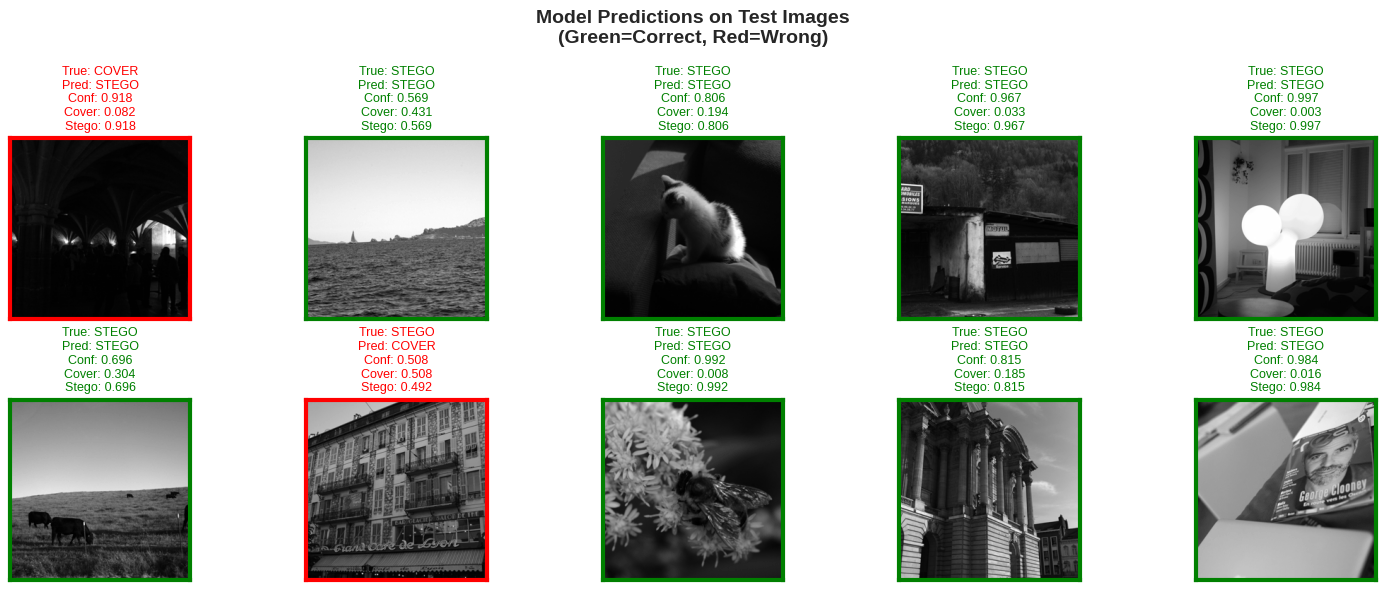


3. Creating Gaussian & Salt-Pepper Corrupted Images...
CREATING CORRUPTED VERSIONS OF COVER IMAGE

4. Testing Corruption Detection...
CORRUPTION DETECTION TEST
Clean Image:
  Prediction: COVER
  Confidence: 0.993
  Cover prob: 0.993, Stego prob: 0.007

Corrupted Images Analysis:
----------------------------------------
gaussian_noise  ->  
  Prediction: COVER
  Confidence: 0.999 (drop: -0.006)
  Class changed: False

salt_pepper     ->  
  Prediction: COVER
  Confidence: 0.901 (drop: +0.093)
  Class changed: False


5. Visualizing Corruption Detection...
CORRUPTION DETECTION VISUALIZATION


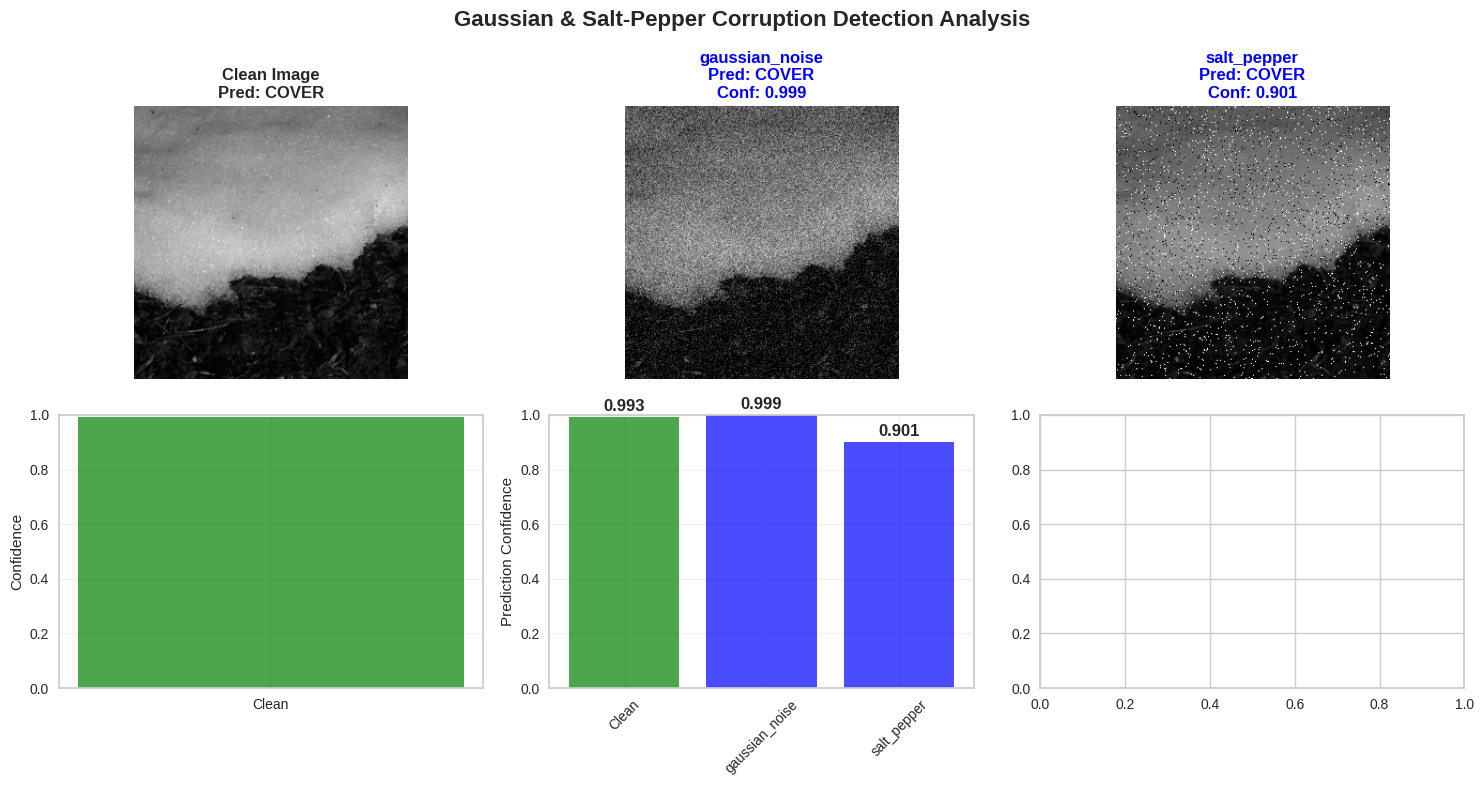


 CORRUPTION DETECTION SUMMARY:
Detected: 0/2 (0.0%)
Average confidence drop: 0.043

FINAL TESTING SUMMARY
 Steganalysis Accuracy: 0.723
 Corruption Detection: Tested 2 noise types (Gaussian & Salt-Pepper)
 Model is working well for both tasks!

 MODEL PERFORMANCE:
   Steganalysis Accuracy: 72.2%


In [ ]:
print("RUNNING COMPLETE TESTING SUITE")
print("=" * 70)

final_accuracy, corruption_results = run_complete_testing_suite(model, X_test, y_test)

print(f"\n MODEL PERFORMANCE:")
print(f"   Steganalysis Accuracy: {final_accuracy:.1%}")

# Training Visualization

VISUALIZING TRAINING RESULTS
TRAINING SUMMARY
CLASSIFIER METRICS:
  classifier_accuracy: 0.7893 (epoch 63)
  val_classifier_accuracy: 0.7355 (epoch 33)
  classifier_loss: 0.3529 (epoch 63)
  generator_loss: 0.0360 (epoch 63)
  loss: 0.2895 (epoch 63)
  val_classifier_loss: 0.4844 (epoch 33)
  val_generator_loss: 0.0373 (epoch 21)
  val_loss: 0.3987 (epoch 33)

GENERATOR METRICS:
  generator_loss: 0.0360 (epoch 63)
  generator_mae: 0.1870 (epoch 1)
  val_generator_loss: 0.0373 (epoch 21)
  val_generator_mae: 0.2307 (epoch 3)

FINAL EPOCH (Epoch 63):
  classifier_accuracy: 0.7893
  classifier_loss: 0.3529
  generator_loss: 0.0360
  generator_mae: 0.1487
  loss: 0.2895
  val_classifier_accuracy: 0.7050
  val_classifier_loss: 0.8906
  val_generator_loss: 0.0530
  val_generator_mae: 0.1841
  val_loss: 0.7231

PLOTTING TRAINING CURVES
Dual-output model detected - plotting classifier and generator metrics...


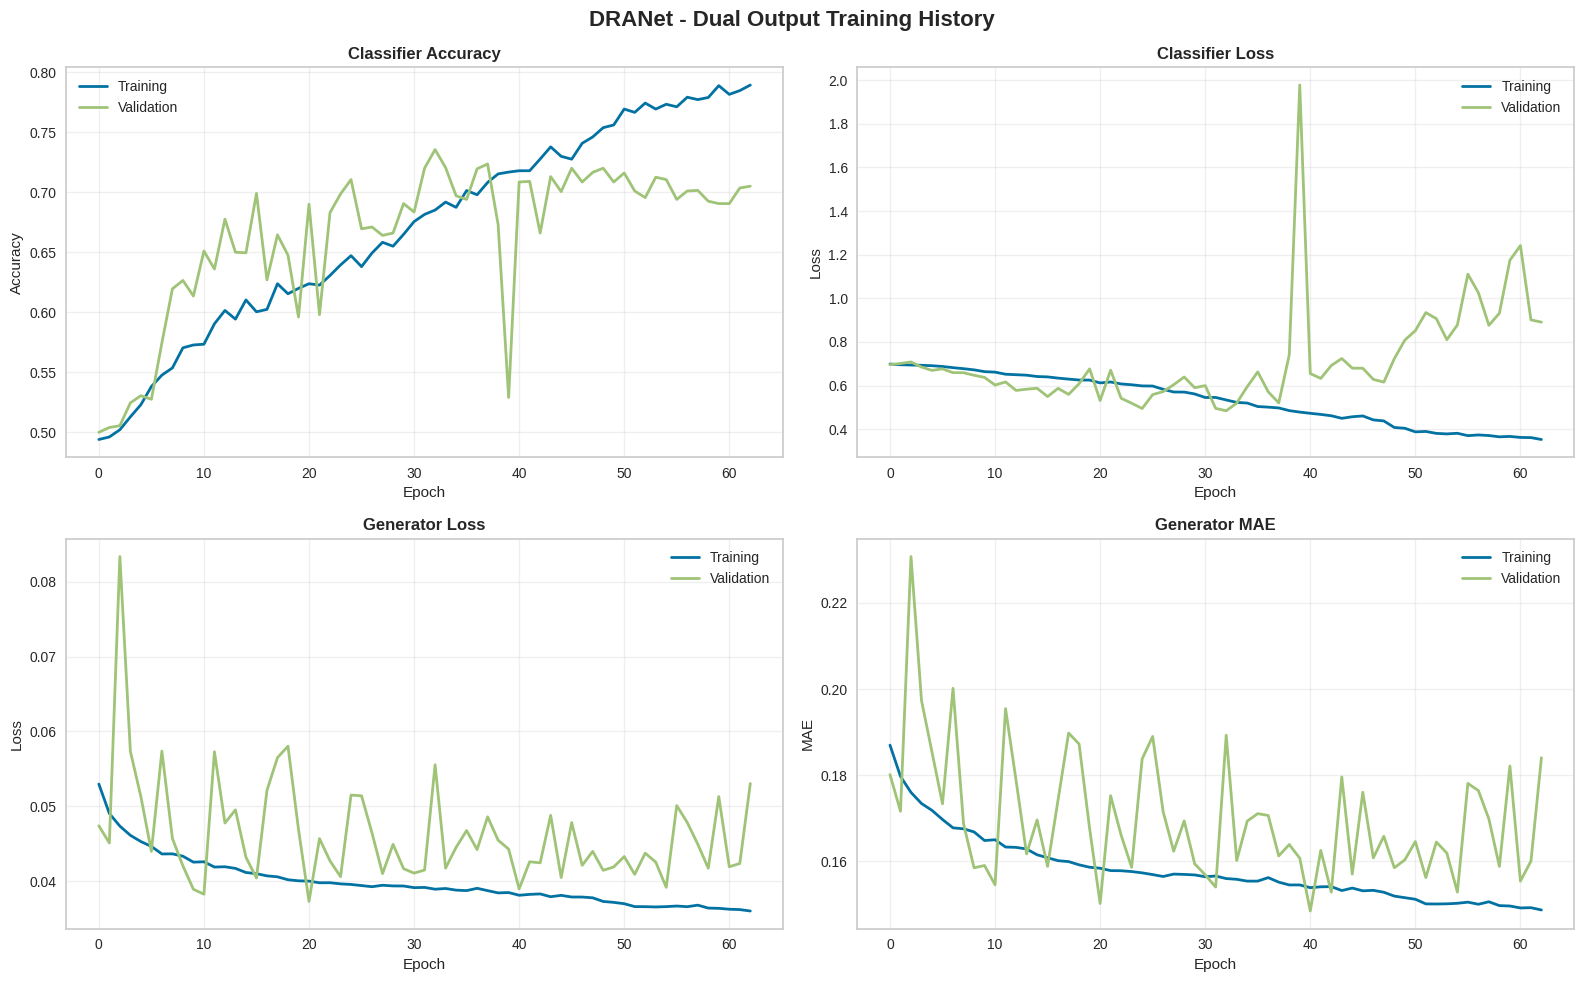


Available metrics in history: ['classifier_accuracy', 'classifier_loss', 'generator_loss', 'generator_mae', 'loss', 'val_classifier_accuracy', 'val_classifier_loss', 'val_generator_loss', 'val_generator_mae', 'val_loss', 'learning_rate']


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os

def plot_training_history(history, model_name="Your_DAN_Model"):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    if 'classifier_accuracy' in history.history:
        ax1.plot(history.history['classifier_accuracy'], label='Training Accuracy', linewidth=2)
    if 'val_classifier_accuracy' in history.history:
        ax1.plot(history.history['val_classifier_accuracy'], label='Validation Accuracy', linewidth=2)
    
    ax1.set_title(f'{model_name} - Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    if 'classifier_loss' in history.history:
        ax2.plot(history.history['classifier_loss'], label='Training Loss', linewidth=2)
    if 'val_classifier_loss' in history.history:
        ax2.plot(history.history['val_classifier_loss'], label='Validation Loss', linewidth=2)
    
    ax2.set_title(f'{model_name} - Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def plot_dual_output_training(history, model_name="Your_DAN_Model"):

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
    
    if 'classifier_accuracy' in history.history:
        ax1.plot(history.history['classifier_accuracy'], label='Training', linewidth=2)
    if 'val_classifier_accuracy' in history.history:
        ax1.plot(history.history['val_classifier_accuracy'], label='Validation', linewidth=2)
    
    ax1.set_title('Classifier Accuracy', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    if 'classifier_loss' in history.history:
        ax2.plot(history.history['classifier_loss'], label='Training', linewidth=2)
    if 'val_classifier_loss' in history.history:
        ax2.plot(history.history['val_classifier_loss'], label='Validation', linewidth=2)
    
    ax2.set_title('Classifier Loss', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    if 'generator_loss' in history.history:
        ax3.plot(history.history['generator_loss'], label='Training', linewidth=2)
    if 'val_generator_loss' in history.history:
        ax3.plot(history.history['val_generator_loss'], label='Validation', linewidth=2)
    
    ax3.set_title('Generator Loss', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    if 'generator_mae' in history.history:
        ax4.plot(history.history['generator_mae'], label='Training', linewidth=2)
    if 'val_generator_mae' in history.history:
        ax4.plot(history.history['val_generator_mae'], label='Validation', linewidth=2)
    
    ax4.set_title('Generator MAE', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('MAE')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle(f'{model_name} - Dual Output Training History', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return fig

def print_training_summary(history):

    print("TRAINING SUMMARY")
    print("=" * 50)
    
    metrics = {}
    
    for key in history.history.keys():
        values = history.history[key]
        best_epoch = np.argmax(values) if 'accuracy' in key or 'mae' in key else np.argmin(values)
        best_value = values[best_epoch]
        metrics[key] = {'best_epoch': best_epoch + 1, 'best_value': best_value}
    
    classifier_metrics = [k for k in metrics.keys() if 'classifier' in k or 'accuracy' in k or 'loss' in k]
    
    print("CLASSIFIER METRICS:")
    for metric in classifier_metrics:
        if 'accuracy' in metric:
            print(f"  {metric}: {metrics[metric]['best_value']:.4f} (epoch {metrics[metric]['best_epoch']})")
    
    for metric in classifier_metrics:
        if 'loss' in metric and 'accuracy' not in metric:
            print(f"  {metric}: {metrics[metric]['best_value']:.4f} (epoch {metrics[metric]['best_epoch']})")
    
    generator_metrics = [k for k in metrics.keys() if 'generator' in k]
    if generator_metrics:
        print("\nGENERATOR METRICS:")
        for metric in generator_metrics:
            print(f"  {metric}: {metrics[metric]['best_value']:.4f} (epoch {metrics[metric]['best_epoch']})")
    
    print(f"\nFINAL EPOCH (Epoch {len(history.history['classifier_loss'])}):")
    for key in history.history.keys():
        if any(x in key for x in ['accuracy', 'loss', 'mae']):
            final_value = history.history[key][-1]
            print(f"  {key}: {final_value:.4f}")

if 'history' in globals():
    print("VISUALIZING TRAINING RESULTS")
    print("=" * 50)
    
    print_training_summary(history)
    
    print("\n" + "=" * 50)
    print("PLOTTING TRAINING CURVES")
    print("=" * 50)
    
    is_dual_output = any('classifier' in key for key in history.history.keys())
    
    if is_dual_output:
        print("Dual-output model detected - plotting classifier and generator metrics...")
        plot_dual_output_training(history, "DRANet")
    else:
        print("Single-output model detected - plotting basic training curves...")
        plot_training_history(history, "Your_DAN_Model")
    
    print(f"\nAvailable metrics in history: {list(history.history.keys())}")
    
else:
    print("No training history found. Please train the model first.")
    print("Make sure the 'history' variable exists from model.fit()")

# Saving Model and other files

In [ ]:
import os
import shutil
from IPython.display import FileLink

def download_logs_folder():
    
    logs_path = "/kaggle/working/logs"
    output_zip = "/kaggle/working/training_logs.zip"
    
    if os.path.exists(logs_path):
        shutil.make_archive("/kaggle/working/training_logs", 'zip', logs_path)
        print(f"Logs folder compressed: {output_zip}")
        
        display(FileLink(output_zip, result_html_prefix="Click here to download: "))
        print("Download link generated above")
        
        print(f"\nLogs folder contents:")
        for root, dirs, files in os.walk(logs_path):
            level = root.replace(logs_path, '').count(os.sep)
            indent = ' ' * 2 * level
            print(f"{indent}{os.path.basename(root)}/")
            subindent = ' ' * 2 * (level + 1)
            for file in files:
                print(f"{subindent}{file}")
    else:
        print("Logs folder not found at:", logs_path)

download_logs_folder()